**Batch Generate Filled Shells from Masked Nuclei**

Aim : To load, threshold, and detect nuceli for futher analysis.

Updates for v4.2

- forget opencv
- targeted file list
- quick but dirty convex hull detection
- automate file naming to avoid errors
- no plots
- run as a for loop

still to do

- prevent overwriting files

In [1]:
##Import modules etc.
import glob
import os
import time
import pandas as pd
import numpy as np
import mahotas as mh
from mahotas.labeled import filter_labeled
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage.measure import regionprops
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects

from scipy import ndimage
from scipy.ndimage import morphology

In [2]:
#[1] Get targeted filelist

path='C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output/'
#path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/'

target='_Mask5.npy'

filelist=glob.glob(path+str('*')+target)

In [3]:
filelist

['C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_0_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_1_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_2_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_3_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_4_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_5_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5A_6_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output\\Well01_HEK293T_eGFP-KDM5

In [4]:
#Specify output directory
output='Shells/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

**Define Functions**

In [5]:
def labelNuceli(mask, min_size = 8000):
#By default min_vol = 8000

    labeled_mask, n_objects=mh.label(mask)
    print('{} objects were detected'.format(n_objects))
    
    labeled_mask = remove_small_objects(labeled_mask, min_size, in_place=True)
    print 'filtered'
    
    #Reset counts  and count the labels, 
    relabeled, n_left = mh.labeled.relabel(labeled_mask)
    print('after filtering and relabeling there are {} nuclei left'.format(n_left))

    return relabeled

In [6]:
def dilateFillErode(stack, remove_bordering = True):

    #Let's do every z slice
    final_stack=np.zeros_like(stack)
    
    for z, frame in enumerate(stack):

        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            blob=morphology.binary_dilation(frame==ll, np.ones((20,20)))
            
            if remove_bordering :
                blob=mh.labeled.remove_bordering(blob)
            filled_blob=morphology.binary_fill_holes(blob)
            reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))*ll
            final=final+reduced

        final_stack[z]=final
    
    return final_stack

In [7]:
def clusterMarkers(markers, collections):

    ##Cluster in z
    marker_props = regionprops(markers, collections) #Use filled mask as intensity image to preserve original labeling

    m_head=['Marker','x','y','z','Collection']
    m_props=[]

    for m in marker_props:

        #Get bounding box
        bb=np.array(m.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))


        m_props.append([int(m.label),
                          xcent,
                          ycent,
                          zcent,
                          m.mean_intensity])
        
    return pd.DataFrame(m_props, columns=m_head)

In [8]:
def watershed3D(big):

    #Calculate 3D distance transform of labeled image
    print 'calculating distance transform'
    distance = ndimage.distance_transform_edt(big)
    
    #Detect local maxima
    print 'calculating distance maxima'
    local_max10 = peak_local_max(distance, indices=False, threshold_abs=5, footprint=np.ones((1, 175, 175)), labels=big)
    
    #Dilate maxima in 3D to collect nearby markers together
    collect=morphology.binary_dilation(local_max10.max(axis=0), np.ones((15,15)))
    
    #Get shape of 'big'
    z_span = int(big.shape[0])
    collect3D = np.repeat(collect[np.newaxis, :, :], z_span, axis=0)
    #collect3D = np.repeat(collect[np.newaxis, :, :], 24, axis=0)
    
    ##Count collections
    collections, n_collections=mh.label(collect3D)
    
    ##Count markers
    markers, n_markers=mh.label(local_max10)
    
    #Tabulate Marker Properties
    Marker_Properties = clusterMarkers(markers, collections)
    
    #Average markers if they are within the same collection
    center_positions = Marker_Properties.groupby('Collection', as_index=False)['x','y','z'].mean().astype(int)
    
    #Make 3D binary
    centers=np.zeros_like(big)

    #Specify True values based on coodinate list
    centers[center_positions['z'], center_positions['y'], center_positions['x']] = center_positions['Collection']

    ##3D watershed with unique centers
    print 'calculating watershed'
    return watershed(image = -distance, markers = centers, mask=big)

In [9]:
def splitLargeObjects(labeled_mask):
       
    #Check for large objects
    big, n_big=mh.labeled.filter_labeled(labeled_mask, min_size=750000)
        
    if (n_big<1):
        return labeled_mask
        print 'no large objects were detected.'
    else:
        print('{} large objects were detected.'.format(n_big))
    
        #Watershed big objects
        print 'watershedding large objects'
        split = watershed3D(big)
        
        #Relabel shells because shells in different watershed may produce discontinuous numbering
        print 'relabling shells'
        
        #Recombine split objects with original by addition
        split, n = mh.labeled.relabel(labeled_mask+split, inplace=True)
        
        return split   

In [10]:
def batchShell(filelist):

    ##Loop through each mask and generate labeled convex hulls
    for ff, ffile in enumerate(filelist):
        #print ff

        #Get filename
        maskfilename = os.path.basename(filelist[ff])
        print maskfilename
               
        #Generate filename for Labeled Shells
        Shellsfilename = maskfilename.replace(target, '_Shells.npy')
        #Generate path for Labeled Shells
        Shellspath = newpath+Shellsfilename

        ##Import mask
        mask5 = np.load(filelist[ff])

        #Relabel nuclei
        relabeled = labelNuceli(mask5)
        
        #Dilate Erode to generate initial mask from nuceli
        print 'generating mask'
        mask6=dilateFillErode(relabeled)
                
        #Save shells
        np.save(Shellspath, mask6)

        #3D watershed large objects
        print 'splitting large objects'
        split = splitLargeObjects(mask6)

        #Generate filename for Labeled Shells
        SplitShellsfilename = maskfilename.replace(target, '_Split_Shells.npy')
        #Generate path for Labeled Shells
        SplitShellspath = newpath+SplitShellsfilename
        
        #Save shells
        np.save(SplitShellspath, split)
    print 'processed'

In [12]:
##Time conversion. ~2h for 3 3D masks.
t0 = time.time() #remember the brackets
batchShell(filelist[3:7])
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)

Well01_HEK293T_eGFP-KDM5A_3_Mask5.npy
719735 objects were detected
filtered
after filtering and relabeling there are 16 nuclei left
generating mask
splitting large objects
3 large objects were detected.
watershedding large objects
calculating distance transform
calculating distance maxima
calculating watershed
relabling shells
Well01_HEK293T_eGFP-KDM5A_4_Mask5.npy
651576 objects were detected
filtered
after filtering and relabeling there are 39 nuclei left
generating mask
splitting large objects
11 large objects were detected.
watershedding large objects
calculating distance transform
calculating distance maxima
calculating watershed
relabling shells
Well01_HEK293T_eGFP-KDM5A_5_Mask5.npy
533271 objects were detected
filtered
after filtering and relabeling there are 35 nuclei left
generating mask
splitting large objects
3 large objects were detected.
watershedding large objects
calculating distance transform
calculating distance maxima
calculating watershed
relabling shells
Well01_HEK29

### END

Trouble shoot Errors below this cell

In [12]:
##Import mask
mask5 = np.load(filelist[1])

In [16]:
int(mask5.shape[0])

35

In [17]:
#Try 3D watershed on saved shells

In [2]:
#Import files
#Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

#Get shell list
shell_list=glob.glob(path+str('/Output/Shells/*Shells.npy'))

In [3]:
shell_list[4]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/Shells\\Well02_HeLa_PHD2-IDR-PHD3_3_Shells.npy'

In [6]:
mask6 = np.load(shell_list[0])

In [ ]:
split = splitLargeObjects(mask6)

(<matplotlib.axes._subplots.AxesSubplot at 0x1c1c7f60>,
 <matplotlib.text.Text at 0x1d21c358>)

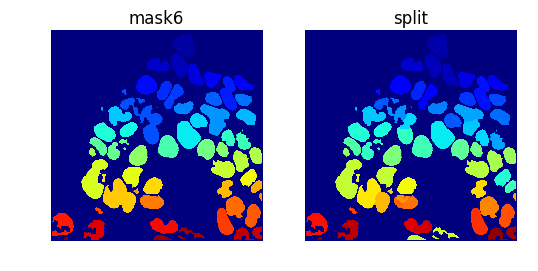

In [62]:
##Compare
plt.subplot(1,2,1), plt.imshow(mask6[4])
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('mask6')
plt.subplot(1,2,2), plt.imshow(split[4])
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('split')

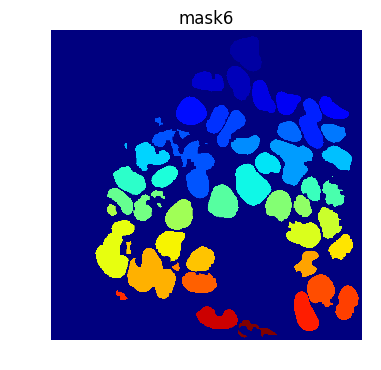

In [7]:
plt.imshow(mask6[4])
plt.axis('off')
plt.title('mask6')

In [73]:
from skimage import feature
ol1=feature.canny(mask6[4]==3)

(<matplotlib.axes._subplots.AxesSubplot at 0x168aca20>,
 <matplotlib.text.Text at 0x4ef755c0>)

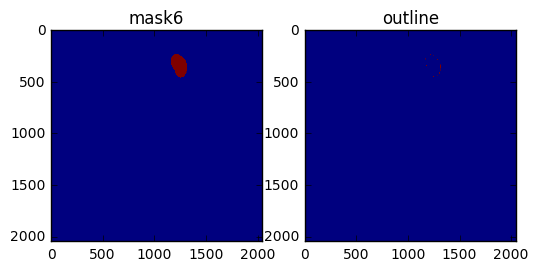

In [75]:
##Compare
plt.subplot(1,2,1), plt.imshow(mask6[4]==3)
plt.subplot(1,2,1), plt.title('mask6')
plt.subplot(1,2,2), plt.imshow(ol1)
plt.subplot(1,2,2), plt.title('outline')

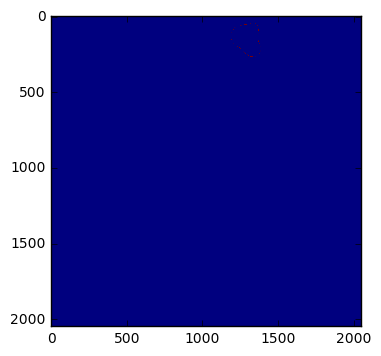

In [59]:
plt.imshow(ol1)

In [8]:
##Plot smooth outline

#2D region props
blob_props = regionprops(mask6[4])

#blob_props[1].coords

from skimage.measure import approximate_polygon
poly = approximate_polygon(blob_props[1].coords, tolerance=0.8)

blob_props[1].bbox

(240L, 1155L, 472L, 1315L)

In [9]:
blob_props[1].coords.shape

(25722L, 2L)

In [10]:
len(np.nonzero(mask6[4]==3)[1])

25722

In [11]:
poly.shape

(464L, 2L)

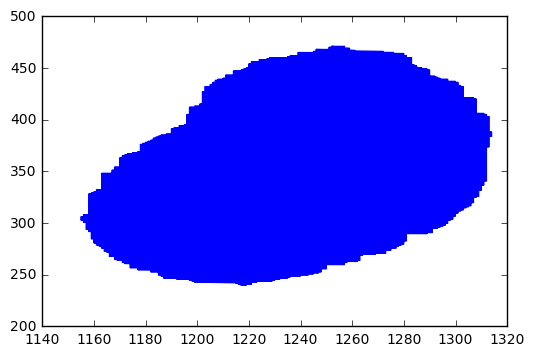

In [12]:
plt.plot(poly[:, 1], poly[:, 0])

In [13]:
from skimage.draw import line_aa, line, polygon, circle, polygon_perimeter
rr, cc = polygon_perimeter(poly[:, 0], poly[:, 1])

In [14]:
[rr, cc]

[array([240, 240, 240, ..., 242, 241, 240], dtype=int64),
 array([1217, 1218, 1219, ..., 1217, 1217, 1217], dtype=int64)]

In [15]:
outline=np.zeros_like(mask6[4])
outline[rr, cc] = 1

(<matplotlib.axes._subplots.AxesSubplot at 0x10b69c88>,
 <matplotlib.text.Text at 0x10b86390>)

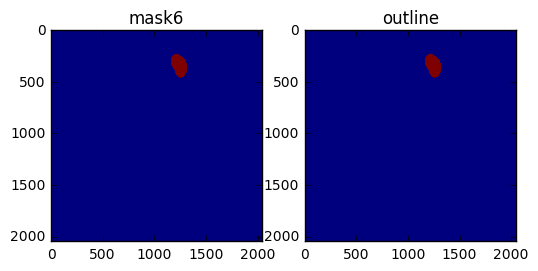

In [16]:
##Compare
plt.subplot(1,2,1), plt.imshow(mask6[4]==3)
plt.subplot(1,2,1), plt.title('mask6')
plt.subplot(1,2,2), plt.imshow(outline)
plt.subplot(1,2,2), plt.title('outline')

In [17]:
from skimage.measure import find_contours

In [18]:
altlines = find_contours(mask6[4], 0.8)

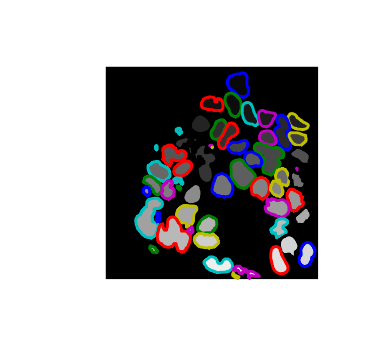

In [20]:
fig, ax = plt.subplots()
ax.imshow(mask6[4], interpolation='nearest', cmap=plt.cm.gray)
ax.axis('off')

for n, altline in enumerate(altlines):
    ax.plot(altline[:, 1], altline[:, 0], linewidth=2)

In [22]:
len(altlines)

55

In [26]:
altlines[2]

array([[  412.8,  1106. ],
       [  412. ,  1105.2],
       [  411.8,  1105. ],
       ..., 
       [  411. ,  1106.8],
       [  412. ,  1106.8],
       [  412.8,  1106. ]])

In [29]:
altlines[2][:,1]

array([ 1106. ,  1105.2,  1105. ,  1104. ,  1103.2,  1103. ,  1102.2,
        1102. ,  1101. ,  1100. ,  1099. ,  1098. ,  1097. ,  1096.2,
        1096. ,  1095. ,  1094. ,  1093. ,  1092. ,  1091. ,  1090. ,
        1089. ,  1088. ,  1087. ,  1086. ,  1085. ,  1084. ,  1083. ,
        1082. ,  1081. ,  1080. ,  1079. ,  1078. ,  1077. ,  1076. ,
        1075. ,  1074. ,  1073. ,  1072. ,  1071. ,  1070. ,  1069.8,
        1069. ,  1068. ,  1067. ,  1066. ,  1065.8,  1065. ,  1064. ,
        1063. ,  1062. ,  1061. ,  1060. ,  1059. ,  1058. ,  1057. ,
        1056.8,  1056. ,  1055.2,  1055. ,  1054. ,  1053. ,  1052.2,
        1052. ,  1051. ,  1050. ,  1049.2,  1049.2,  1049.2,  1049.2,
        1049. ,  1048. ,  1047. ,  1046. ,  1045. ,  1044. ,  1043. ,
        1042.2,  1042. ,  1041. ,  1040. ,  1039. ,  1038. ,  1037. ,
        1036. ,  1035. ,  1034. ,  1033.2,  1033. ,  1032. ,  1031. ,
        1030. ,  1029.2,  1029.2,  1029.2,  1029. ,  1028. ,  1027. ,
        1026. ,  102

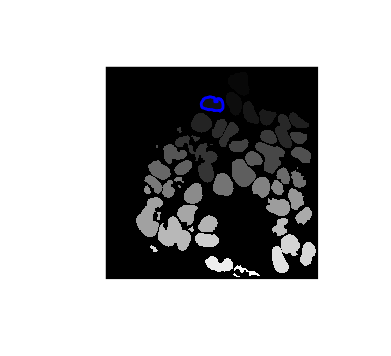

In [30]:
fig, ax = plt.subplots()
ax.imshow(mask6[4], interpolation='nearest', cmap=plt.cm.gray)
ax.axis('off')

ax.plot(altlines[2][:, 1], altlines[2][:, 0], linewidth=2)

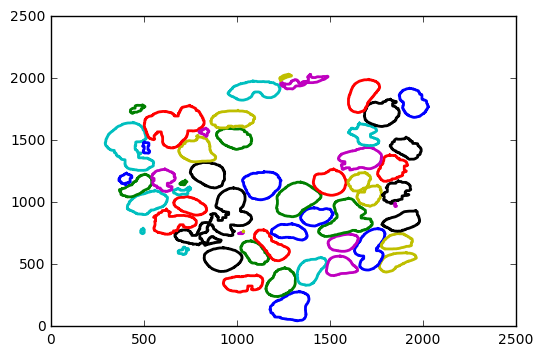

In [196]:
#NEED TO CONVERT R,C vs X,Y

for n, altline in enumerate(altlines):
    plt.plot(altline[:, 1], altline[:, 0], linewidth=2)

In [177]:
rr, cc = polygon_perimeter(altline[:, 0], altline[:, 1])
altline[rr, cc] = 1

TypeError: list indices must be integers, not tuple